## Welcome to your notebook.


In [1]:
import sys
!{sys.executable} -m conda install -y osmnx -c conda-forge
#!{sys.executable} -m pip install geopandas

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



#### Run this cell to connect to your GIS and get started:

In [2]:
import arcgis
from arcgis.gis import GIS
import pandas
import geopandas
import json
import datetime
import numpy as np
import osmnx as ox

In [3]:
gis = GIS("home")

/opt/conda/lib/python3.9/site-packages/arcgis/gis/__init__.py:597: UserWarning: You are logged on as jbousqui_EPA with an administrator role, proceed with caution.
  warnings.warn(


#### Functions

General

In [4]:
def sample(df, n=100):
    return df.sample(n=n, axis='index')

For OSMnx

In [5]:
def OD_bbox(origins, destinations):
    """Get bounding box for two sets of points"""
    # minx, miny, maxx, maxy
    #expected maxy, miny, maxx, minx
    # TODO: add 1000m to bbox (inline with graph from point)
    #clean_periphery uses 500m
    o_bbox = origins.to_crs(4326).total_bounds
    d_bbox = destinations.to_crs(4326).total_bounds
    #od_bbox = [min(o_bbox[0], d_bbox[0]), min(o_bbox[1], d_bbox[1]), max(o_bbox[2], d_bbox[2]), max(o_bbox[3], d_bbox[3])]
    return {'minx': min(o_bbox[0], d_bbox[0]), 
            'miny': min(o_bbox[1], d_bbox[1]),
            'maxx': max(o_bbox[2], d_bbox[2]), 
            'maxy': max(o_bbox[3], d_bbox[3])
            }

In [6]:
def default_network(origins, destinations, mode="drive"):
    """Retrieve network using bounding box around origins and destinations"""
    bbox_dict = OD_bbox(origins, destinations)
    # Get ox network
    G = ox.graph_from_bbox(bbox_dict['maxy'],
                           bbox_dict['miny'],
                           bbox_dict['maxx'],
                           bbox_dict['minx'],
                           network_type=mode)
    # impute speed on all edges missing data
    G = ox.add_edge_speeds(G)
    # calculate travel time (seconds) for all edges
    G = ox.add_edge_travel_times(G)
    return G

In [7]:
def on_network(points, G):
    """Locate points on OSMnx network"""
    Gp = ox.project_graph(G)  # Faster to run this once for O-D
    # Get CRS (should be location based UTM)
    crs = ox.graph_to_gdfs(Gp, nodes=False).crs
    points = points.to_crs(crs)
    X_series = points['geometry'].x
    Y_series = points['geometry'].y
    
    nodes, dists = ox.nearest_nodes(Gp, X_series, Y_series, return_dist=True)
    return pandas.DataFrame({'Nearest_Node': nodes,
                             'Offset_Distance': dists})

In [8]:
def OD_matrix(origin_nodes, destination_nodes, graph, weight="travel_time"):
    """Get origin destination table using OSMnx graph"""
    assert weight in ["length", "travel_time"], 'Weight not recognized'
    routes = []
    routes_d = []
    for i, orig in enumerate(origin_nodes):
        for j, dest in enumerate(destination_nodes):
            route = ox.shortest_path(G, orig, dest, weight=weight)
            routes.append(route)
            routes_d.append(
                {
                    'Origin': i,
                    'Destination': j,
                    'Distance (m)': int(sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))),
                    'Travel_Time (s)': int(sum(ox.utils_graph.get_route_edge_attributes(G, route, "travel_time"))),
                }
            )
            #ox.utils_graph.get_route_edge_attributes(G, route) # all attribtues
            #route_length_col.append()
            #route_time_col.append(sum(ox.utils_graph.get_route_edge_attributes(G, route, "travel_time")))
    df = pandas.DataFrame(routes_d)
    df['Travel_Time'] = [str(datetime.timedelta(seconds=sec)) for sec in df['Travel_Time (s)']]
    return df, routes

 For ESRI service

In [9]:
def gdf_to_featJSON(gdf):
    """Convert geodataframe to json in esri expected format"""
    temp_gdf = gdf.copy().to_crs(4326)
    feats = json.loads(temp_gdf['geometry'].to_json())['features']
    #return {'features':[{'id':item['id'], 'geometry':item['geometry']['coordinates']} for item in feats]}
    #return {'features':[{'geometry':item['geometry']['coordinates']} for item in feats]}
    return {'features':[{'geometry':{"x":item['geometry']['coordinates'][0], 
                                     "y":item['geometry']['coordinates'][1]}} for item in feats]}

In [10]:
def get_od_matrix(origin_gdf, destination_gdf, mode='Drive', impedance='TravelTime'):
    """ Requires license but uses 0.1 credits"""
    # Setup
    origins_json = gdf_to_featJSON(origin_gdf)  # Set json
    destinations_json = gdf_to_featJSON(destination_gdf)  # Set json
    gis = GIS("home") # set object
    # Service
    od_cost_matrix = arcgis.network.ODCostMatrixLayer(gis.properties.helperServices.odCostMatrix.url, gis=gis)
    # Solve
    return od_cost_matrix.solve_od_cost_matrix(origins=origins_json, destinations=destinations_json)

In [11]:
def get_simple_routes(origin_gdf, destination_gdf, mode='Drive', impedance='TravelTime'):
    """
    If you have an ArcGIS Developer account, simple routes are included with the monthly free tier of access to location services
    """
    # Setup
    origins_json = gdf_to_featJSON(origin_gdf)  # Set json
    destinations_json = gdf_to_featJSON(destination_gdf)  # Set json
    gis = GIS("home") # set object
    # Service
    od_route = arcgis.network.RouteLayer(gis.properties.helperServices.route.url, gis=gis)
    # Solve
    results = {}
    for i, origin in enumerate(origins_json['features']):
        results[str(i+1)] = {}
        for j, dest in enumerate(destinations_json['features']):
            stops = "{"+ "'features':[{},{}]".format(origin, dest) + "}"
            result = od_route.solve(stops=stops, return_directions=False)
            results[str(i+1)][str(j+1)] = result
    return results

In [12]:
def od_matrix_to_df(result):
    """parse get_od_matrix() result to expected dataFrame"""
    # number of destinations
    dest_ids = list(result['odCostMatrix']['1'].keys())  #TODO: always '1'?
    # TODO: dict keys are not sorted - will numbers always be after letters?
    orig_ids = list(result['odCostMatrix'].keys())[1:]
    cols = result['odCostMatrix']['costAttributeNames']
    origins_list = orig_ids * len(dest_ids)
    origins_list.sort()
    # Structure data for df
    data = {'Origin': origins_list,
            'Destination': dest_ids * len(orig_ids),
            cols[0]: [],
            cols[1]: [],
            cols[2]: [],
           }
    # Add results to data
    for i, orig in enumerate(data['Origin']):
        dest = data['Destination'][i]
        row = result['odCostMatrix'][orig][dest]
        data[cols[0]].append(row[0])
        data[cols[1]].append(row[1])
        data[cols[2]].append(row[2])
    df = pandas.DataFrame(data)
    # Convert min to datetime hr:min:sec
    df['TravelTime'] = [int(x*60) for x in df['TravelTime']]
    df['Travel_Time'] = [str(datetime.timedelta(seconds=sec)) for sec in df['TravelTime']]
    df['Distance (m)'] = [int(x*1000) for x in df['Kilometers']]
    return df

In [13]:
def simple_routes_to_df(routes):
    """parse get_simple_routes() result to expected dataFrame"""
    dest_ids = list(routes['1'].keys())
    orig_ids = list(routes.keys())
    origins_list = orig_ids * len(dest_ids)
    origins_list.sort()
    # Structure data for df
    data = {'Origin': origins_list,
            'Destination': dest_ids * len(orig_ids),
            'TravelTime': [],
            'Miles': [],
            'Kilometers': [],
           }
    # Add results to data
    for i, orig in enumerate(data['Origin']):
        dest = data['Destination'][i]
        row = routes[orig][dest]['routes']['features'][0]['attributes']
        data['TravelTime'].append(row['Total_TravelTime'])
        data['Miles'].append(row['Total_Miles'])
        data['Kilometers'].append(row['Total_Kilometers'])
    # Fix up df
    df = pandas.DataFrame(data)
    # Convert min to datetime hr:min:sec
    df['TravelTime'] = [int(x*60) for x in df['TravelTime']]
    df['Travel_Time'] = [str(datetime.timedelta(seconds=sec)) for sec in df['TravelTime']]
    df['Distance (m)'] = [int(x*1000) for x in df['Kilometers']]
    # geometry for route
    routes_geom = routes['1']['1']['routes']['features'][0]['geometry']['paths']

    return df, routes_geom

In [14]:
#od_route = arcgis.network.RouteLayer(gis.properties.helperServices.route.url, gis=gis)
#od_route.properties

In [15]:
# look through default params to simplify what is returned
#?od_route.solve

In [16]:
# OD result to match
#{'messages': [],
# 'requestID': '92d5fa96-1797-4e11-8994-599acc462e7e',
# 'odCostMatrix': {'costAttributeNames': ['TravelTime', 'Miles', 'Kilometers'],
#  '1': {'1': [29.00011563705884, 15.799481549405224, 25.426441215335696],
#   '2': [20.651762527039445, 8.666882913697822, 13.947933727047413]},
#  '2': {'1': [24.41673715691378, 12.498608786498693, 20.114038859356537],
#   '2': [10.019493988683019, 4.6505043089943126, 7.484483960410696]}}}

https://developers.arcgis.com/documentation/mapping-apis-and-services/routing/travel-cost-matrix/

In [17]:
#arcGIS and google packages?
#esri_api_key = "your key goes here"
#portal = GIS("https://www.arcgis.com", api_key=api_key)

#### Run on Origins and Destinations

In [18]:
# User variables
#mode = 'walk'  # 'walk' or 'drive' (default)
origins_shp = '/arcgis/home/All_Parcels_Tracts_within_Centroids2_1222022.shp'
destinations_shp = '/arcgis/home/ParksandRec_Tracts_within_12232022.shp'

In [19]:
# read shp to geodataframe
origins_all = geopandas.read_file(origins_shp)
destinations_all = geopandas.read_file(destinations_shp)

In [20]:
# Get subset
origins_sub = sample(origins_all, n=10)
destinations_sub = sample(destinations_all, n=10)

#### OSMnx Route

In [21]:
# Get network
G = default_network(origins_sub, destinations_sub)

In [22]:
# Locate origins on network
o_df = on_network(origins_sub, G)
o_df

,Nearest_Node,Offset_Distance
0,97358893,49.860255
1,97405617,56.984180
2,97358277,32.928827
3,97518582,256.347059
4,97447024,102.777676
5,2021897329,62.247426
6,97405708,172.175156
7,97405708,84.750701
8,97536411,370.507559
9,97338369,99.127035


In [23]:
# Locate destinations on network
d_df = on_network(destinations_sub, G)
d_df

,Nearest_Node,Offset_Distance
0,4330206960,19.020756
1,9796675703,254.411199
2,97376245,170.456395
3,97423085,133.677404
4,97464638,91.222264
5,1516500125,88.148949
6,97376179,84.626057
7,100578614,658.061382
8,97424681,115.752880
9,100595362,1987.920640


In [24]:
# Find the shortest path (by traveltime)
df_osm, routes_osm = OD_matrix(o_df['Nearest_Node'], d_df['Nearest_Node'], G)

In [25]:
df_osm

,Origin,Destination,Distance (m),Travel_Time (s),Travel_Time
0,0,0,11210,681,0:11:21
1,0,1,17441,933,0:15:33
2,0,2,19803,1258,0:20:58
3,0,3,7448,438,0:07:18
4,0,4,7820,443,0:07:23
...,...,...,...,...,...
95,9,5,7450,468,0:07:48
96,9,6,22336,1270,0:21:10
97,9,7,45922,2776,0:46:16
98,9,8,22894,1306,0:21:46


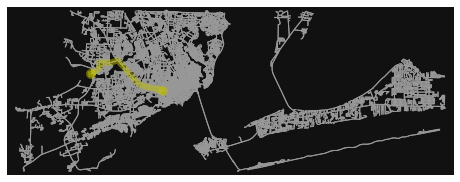

In [26]:
# Plot first route
fig, ax = ox.plot_graph_route(G, routes_osm[0], route_color="y", route_linewidth=6, node_size=0)

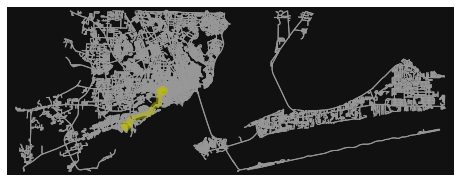

In [27]:
# Plot last route
fig, ax = ox.plot_graph_route(G, routes_osm[3], route_color="y", route_linewidth=6, node_size=0)

#### OD Service

In [28]:
# run subset using esri OD service
result_od = get_od_matrix(origins_sub, destinations_sub)

/opt/conda/lib/python3.9/site-packages/arcgis/gis/__init__.py:597: UserWarning: You are logged on as jbousqui_EPA with an administrator role, proceed with caution.
  warnings.warn(


In [29]:
df_od = od_matrix_to_df(result_od)

#### Route Service

In [30]:
# run subset using esri route service
result_routes = get_simple_routes(origins_sub, destinations_sub)

/opt/conda/lib/python3.9/site-packages/arcgis/gis/__init__.py:597: UserWarning: You are logged on as jbousqui_EPA with an administrator role, proceed with caution.
  warnings.warn(


In [31]:
df_routes, routes_esri = simple_routes_to_df(result_routes)

#### Comparisons

##### df_od == df_routes

In [32]:
df_od == df_routes

,Origin,Destination,TravelTime,Miles,Kilometers,Travel_Time,Distance (m)
0,True,True,True,False,False,True,True
1,True,True,True,True,True,True,True
2,True,True,True,True,False,True,True
3,True,True,True,True,True,True,True
4,True,True,True,False,True,True,True
...,...,...,...,...,...,...,...
95,True,True,True,True,True,True,True
96,True,True,False,False,False,False,False
97,True,True,True,True,True,True,True
98,True,True,False,False,False,False,False


<AxesSubplot:>

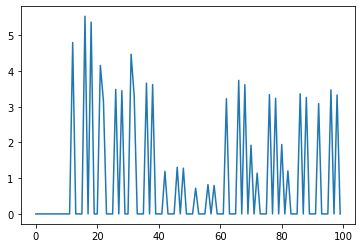

In [64]:
# Compare travel time
pct_esri_time = ((df_od['TravelTime'] - df_routes['TravelTime'])/df_od['TravelTime'])*100
#3 x-axis is index, y-axis is percent disagreement
pct_esri_time.plot()

<AxesSubplot:xlabel='TravelTime'>

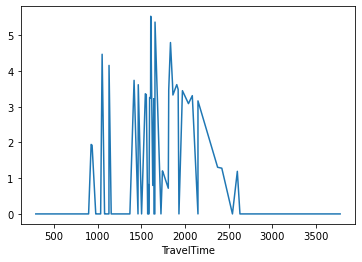

In [65]:
# look for pattern with increasing travel time?
pct_esri_time.index = df_od['TravelTime']
pct_esri_time = pct_esri_time.sort_index()
pct_esri_time.plot()

<AxesSubplot:>

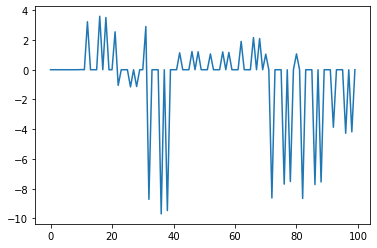

In [69]:
# Compare travel distance (m)
pct_esri_dist = ((df_od['Distance (m)'] - df_routes['Distance (m)'])/df_od['Distance (m)'])*100
#3 x-axis is index, y-axis is percent disagreement
pct_esri_dist.plot()

<AxesSubplot:xlabel='Distance (m)'>

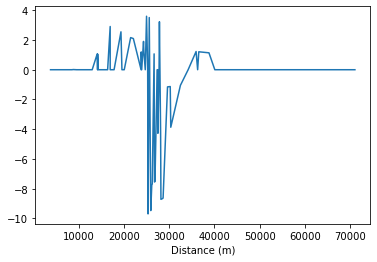

In [70]:
# look for pattern with increasing distance?
pct_esri_dist.index = df_od['Distance (m)']
pct_esri_dist = pct_esri_dist.sort_index()
pct_esri_dist.plot()

In [72]:
#df_od

In [71]:
#df_routes

##### df_od vs df_osm

In [36]:
df_osm

,Origin,Destination,Distance (m),Travel_Time (s),Travel_Time
0,0,0,11210,681,0:11:21
1,0,1,17441,933,0:15:33
2,0,2,19803,1258,0:20:58
3,0,3,7448,438,0:07:18
4,0,4,7820,443,0:07:23
...,...,...,...,...,...
95,9,5,7450,468,0:07:48
96,9,6,22336,1270,0:21:10
97,9,7,45922,2776,0:46:16
98,9,8,22894,1306,0:21:46


Distance (as percent)

<AxesSubplot:>

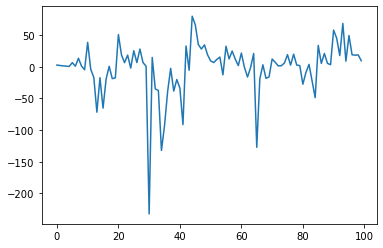

In [67]:
diff_dist = ((df_od['Distance (m)'] - df_osm['Distance (m)'])/df_od['Distance (m)'])*100
diff_dist.plot()

<AxesSubplot:xlabel='Distance (m)'>

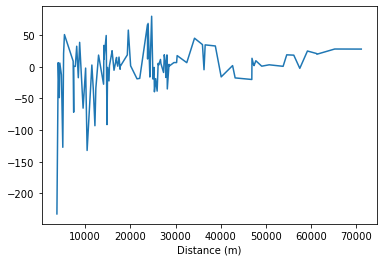

In [73]:
# look for pattern with increasing distance?
diff_dist.index = df_od['Distance (m)']
diff_dist = diff_dist.sort_index()
diff_dist.plot()

Travel Time (as percent)

<AxesSubplot:>

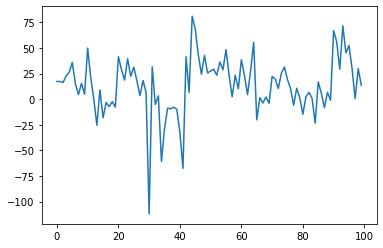

In [68]:
diff_time = ((df_od['TravelTime'] - df_osm['Travel_Time (s)'])/df_od['TravelTime'])*100
diff_time.plot()

<AxesSubplot:xlabel='TravelTime'>

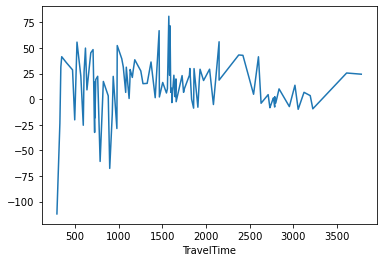

In [74]:
# look for pattern with increasing time?
diff_time.index = df_od['TravelTime']
diff_time = diff_time.sort_index()
diff_time.plot()

#### Notes

FYI on Google API

https://developers.google.com/maps/documentation/distance-matrix

https://github.com/googlemaps/google-maps-services-python (not sure we need this overhead vs maintanability)

In [39]:
#google_api_key = "your key goes here"

In [40]:
#https://maps.googleapis.com/maps/api/distancematrix/json
#  ?destinations=New%20York%20City%2C%20NY
#  &origins=Washington%2C%20DC
#  &units=imperial
#  &key=google_api_key

In [41]:
#googleTxt = 
#"https://maps.googleapis.com/maps/api/distancematrix/" + outType + "?units=" + units + "&origins=" + origin + "&destinations=" + destination
#https://developers.google.com/maps/

Other

In [42]:
#minx, miny, maxx, maxy
#o_bbox = origins_all.to_crs(4326).total_bounds
#d_bbox = destinations_all.to_crs(4326).total_bounds
#od_bbox = [min(o_bbox[0], d_bbox[0]), min(o_bbox[1], d_bbox[1]), max(o_bbox[2], d_bbox[2]), max(o_bbox[3], d_bbox[3])]
#od_bbox

In [43]:
#travel_mode
#https://developers.arcgis.com/rest/network/api-reference/origin-destination-cost-matrix-service.htm#GUID-0429E6BF-F5BA-4FC2-8D51-9E7E63FD8AB4

In [44]:
# example
#test_o = {"features":[{"geometry":{"x":-118.245843,"y":34.057794}},{"geometry":{"x":-117.16274,"y":32.719178}}]}
#test_d = {"features":[{"geometry":{"x":-117.182676,"y":34.055909}},{"geometry":{"x":-118.144184,"y":34.147832}}]}
#result = od_cost_matrix.solve_od_cost_matrix(origins=test_o, destinations=test_d)

In [45]:
# limits on time or distance? TravelTime is default
#impedanceAttributeName= [TravelTime | Minutes | TruckTravelTime | TruckMinutes | WalkTime | Miles | Kilometers]

In [46]:
#travel_mode
#https://developers.arcgis.com/rest/network/api-reference/origin-destination-cost-matrix-service.htm#GUID-0429E6BF-F5BA-4FC2-8D51-9E7E63FD8AB4
# 'The walking speed is set to 5 kilometers per hour.''